# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
1. pytorch // [инструкция по установке](https://pytorch.org/)
2. torchvision // pip install ...
3. matplotlib  //
4. PIL
5. scipy
6. numpy
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
#скелет выхода
def out_size (x, kernel, stride=(1,1), padding=(0,0)):
    B = x.size()[0]
    C = x.size()[1]
    H = x.size()[2]
    W = x.size()[3]
    
    h_out = math.floor((H + 2*padding[0] - kernel.size()[1])/stride[0] + 1) #вычисляем размеры выходного тензора
    w_out = math.floor((W + 2*padding[1] - kernel.size()[2])/stride[1] + 1)
    
    S = torch.FloatTensor(B,C, h_out, w_out).fill_(0)
    return S

In [11]:
#паддинг + заполнение
def padd(x, padding = (0,0)):
    B = x.size()[0]
    C = x.size()[1]
    H = x.size()[2]
    W = x.size()[3]
    xu = torch.FloatTensor(B, C, H + 2*padding[0], W + 2*padding[1]).fill_(0)
    
    for f in range(B):
        for i in range(C):
            for j in range(H):
                for k in range(W):
                    xu[f][i][j+padding[0]][k+padding[1]] = x[f][i][j][k]
                    
    return xu

In [3]:
# прототип функции 
def my_conv2d(x, kernel, stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    
    x = x.unsqueeze(0) #добавить размерность если пришла одна картинка
    S = out_size(x, kernel, stride, padding)
    xu = padd(x, padding)
    
    B = x.size()[0]
    C = x.size()[1]
    H = x.size()[2]
    W = x.size()[3]
    h_out = S.size()[2]
    w_out = S.size()[3]
    
    #сама свертка
    for f in range(B):
        for k in range(C):
            for i in range(h_out):
                for j in range(w_out):
                    minor = xu[f][:, i*stride[1] + padding[1]: i*stride[1] + padding[1]+ kernel.shape[1], 
                                    j*stride[0] + padding[0]: j*stride[0] + padding[0] + kernel.shape[2]]
                    if (kernel[0].shape == minor[0].shape):
                        S[f][k][i][j] = torch.sum(kernel*minor)
                    else:
                        pass
                        
    return S.squeeze(0)[0]

In [4]:
# функции тестирования
from tests_functions import * 

In [5]:
help (test_conv)

Help on function test_conv in module tests_functions:

test_conv(conv_image, test_image_path, bin_test=True)
    Tests convolution results
    Args:
    conv_image: tensor: result tensor of convolved image
    test_image_path: str: path to true tensor saved before



### Загружаем картинку 

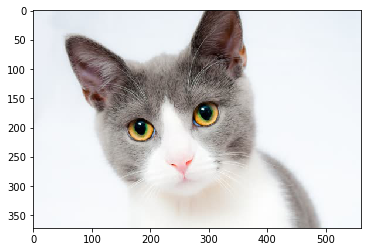

In [6]:
import torch
import torchvision as tv
import math

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [7]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [8]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

In [9]:
#from torch.nn.functional import conv2d
#cat_tensor = cat_tensor.unsqueeze(0)

xu:  torch.Size([1, 3, 372, 560])
torch.Size([370, 558])


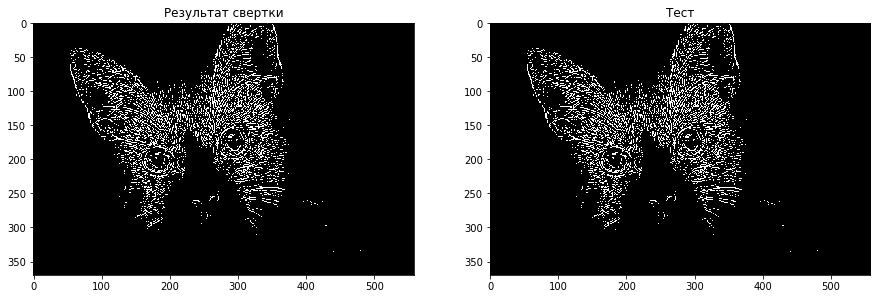

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [12]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


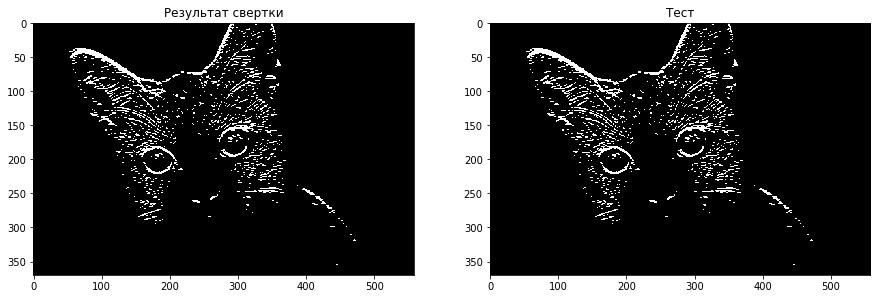

In [13]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [14]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


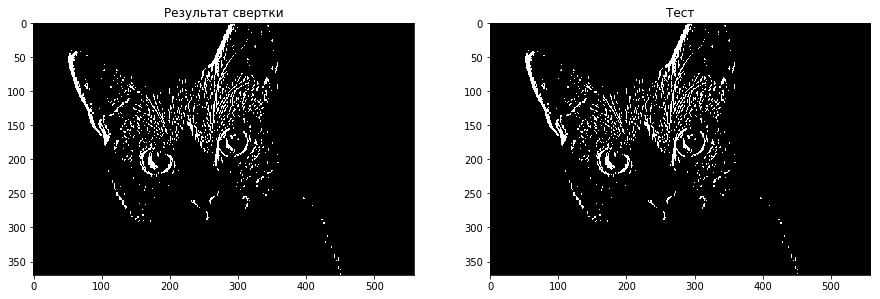

In [15]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth', False)

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


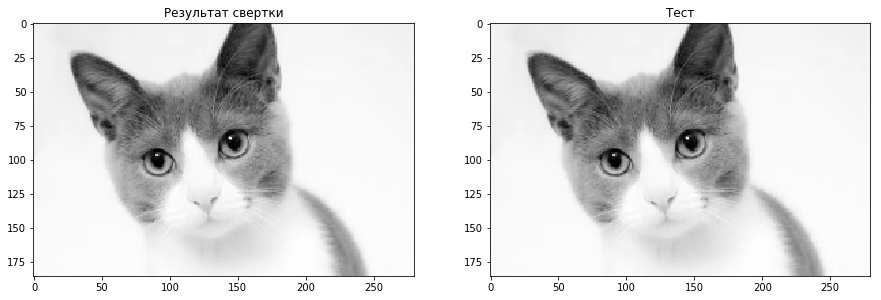

In [16]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([373, 561])


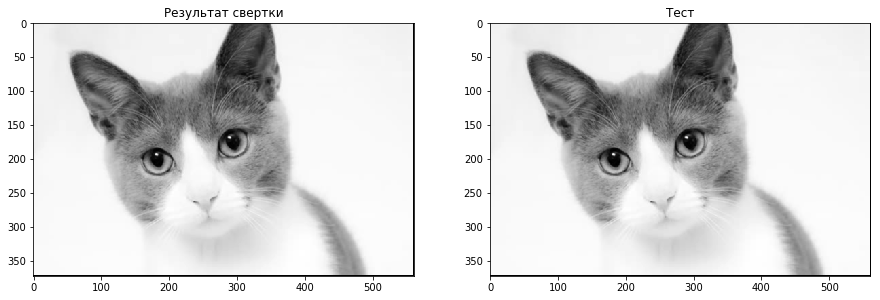

In [17]:
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])


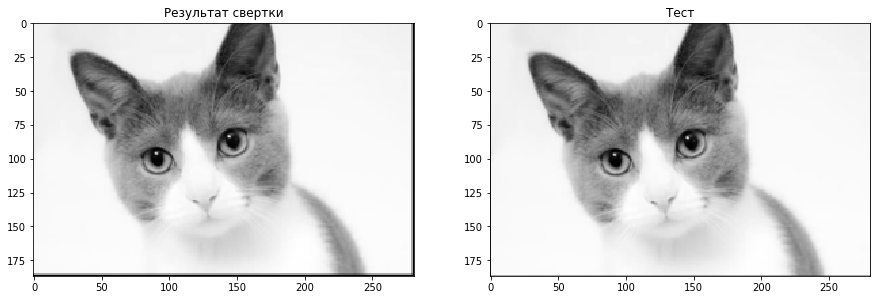

In [18]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth', False)

### Ядро свертки с гаусовым распределением

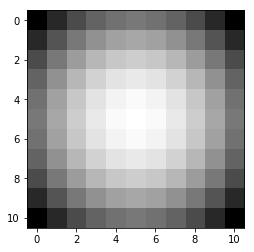

In [19]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем свертку 

torch.Size([362, 550])


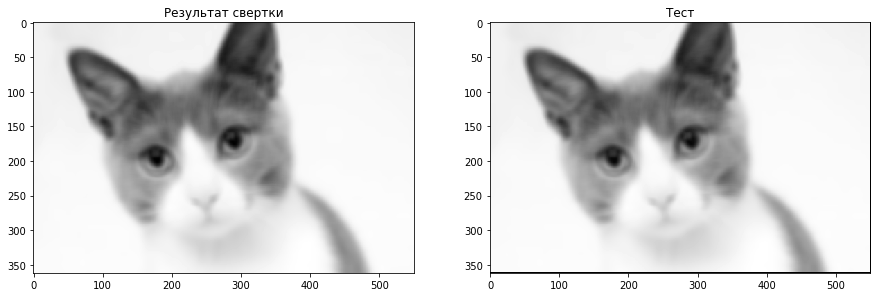

In [20]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - расширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [142]:
from torch.nn import BatchNorm2d

In [480]:
import torch.nn as nn


class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.1, epsilon=1e-5):
        super().__init__()
        self.in_channels = in_channels
        self.beta = beta
        self.epsilon = epsilon
        self.training = True
        self.V = torch.zeros(in_channels)
        self.S = torch.ones(in_channels)
        self.runing_mean = torch.zeros(in_channels)
        self.runing_var = torch.zeros(in_channels)
        self.afine = afine
        
        if self.afine:
            self.weights = torch.Tensor(self.in_channels).uniform_()
            self.bias = torch.zeros(self.in_channels)
        
    def forward(self, x):
        X = torch.FloatTensor(x.shape)
        X = X.new_tensor(x)
        if self.training:
            
            for chan in range(self.in_channels):
                mu = torch.mean(X[:,chan])
                sigm = torch.var(X[:,chan])
                print('mu: ',mu)
                print('sigm: ',sigm)
                
                self.V[chan] = self.beta*self.V[chan] + (1-self.beta)*mu
                self.S[chan] = self.beta*self.S[chan] + (1-self.beta)*sigm**2
                
                X[:,chan] = (X[:,chan] - self.V[chan])/(self.S[chan]+self.epsilon)**0.5
            
        self.runing_mean = self.V
        self.runing_var = self.S**0.5
            
        if self.afine:
            for chan in range(self.in_channels):
                X[:,chan] = X[:,chan]*self.weights[chan] + self.bias[chan]
        return X

### Проверяем работу батч нормадлизации на котэ

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


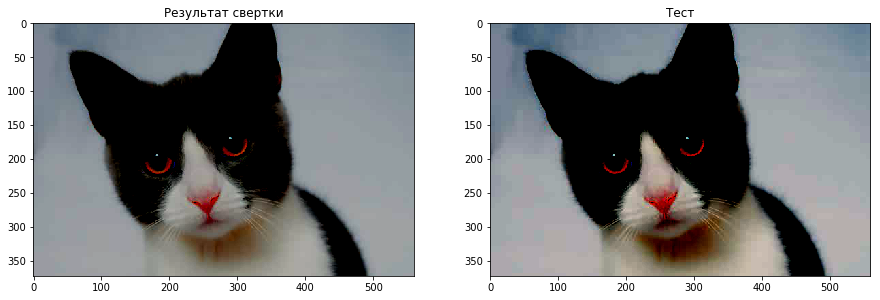

In [464]:
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_01.pth', False)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


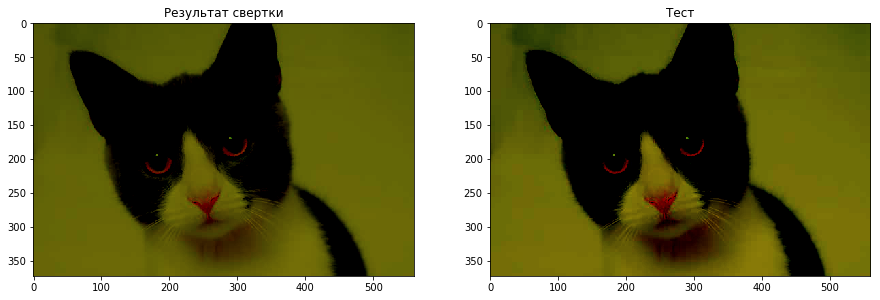

In [465]:
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth', False)
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [466]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [467]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


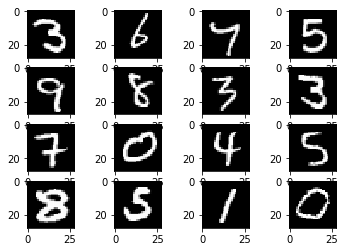

In [468]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [481]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [482]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


mu:  tensor(32.5352)
sigm:  tensor(6139.2007)
mu:  tensor(32.9790)
sigm:  tensor(6087.0762)
mu:  tensor(32.4641)
sigm:  tensor(5958.3613)
mu:  tensor(33.2631)
sigm:  tensor(6153.7202)
mu:  tensor(31.4953)
sigm:  tensor(5842.9321)
mu:  tensor(34.6484)
sigm:  tensor(6359.5015)
mu:  tensor(33.4206)
sigm:  tensor(6242.4224)
mu:  tensor(30.5053)
sigm:  tensor(5667.8540)
mu:  tensor(32.3993)
sigm:  tensor(6003.9146)
mu:  tensor(29.5945)
sigm:  tensor(5565.9229)
mu:  tensor(33.1571)
sigm:  tensor(6156.4106)
mu:  tensor(32.4938)
sigm:  tensor(5954.6313)
mu:  tensor(36.3489)
sigm:  tensor(6654.3691)
mu:  tensor(35.1911)
sigm:  tensor(6493.3843)
mu:  tensor(35.1788)
sigm:  tensor(6503.7505)
mu:  tensor(35.3576)
sigm:  tensor(6545.6689)
mu:  tensor(31.6605)
sigm:  tensor(5850.2471)
mu:  tensor(31.7406)
sigm:  tensor(5855.4702)
mu:  tensor(34.4998)
sigm:  tensor(6352.1348)
mu:  tensor(33.4709)
sigm:  tensor(6249.4546)
mu:  tensor(32.4527)
sigm:  tensor(6037.8315)
mu:  tensor(35.9104)
sigm:  tensor

mu:  tensor(32.9139)
sigm:  tensor(6092.5337)
mu:  tensor(32.2260)
sigm:  tensor(5907.8164)
mu:  tensor(35.7893)
sigm:  tensor(6605.4019)
mu:  tensor(36.3208)
sigm:  tensor(6667.6587)
mu:  tensor(34.3410)
sigm:  tensor(6379.4033)
mu:  tensor(30.0122)
sigm:  tensor(5615.4956)
mu:  tensor(35.4806)
sigm:  tensor(6478.5620)
mu:  tensor(32.8506)
sigm:  tensor(6126.9761)
mu:  tensor(33.3871)
sigm:  tensor(6201.3330)
mu:  tensor(32.8784)
sigm:  tensor(6071.5425)
mu:  tensor(33.9741)
sigm:  tensor(6238.8086)
mu:  tensor(33.6619)
sigm:  tensor(6193.0610)
mu:  tensor(31.6537)
sigm:  tensor(5874.1338)
mu:  tensor(35.0837)
sigm:  tensor(6414.3770)
mu:  tensor(32.6512)
sigm:  tensor(6027.1782)
mu:  tensor(32.2052)
sigm:  tensor(5929.9258)
mu:  tensor(32.6547)
sigm:  tensor(6062.8481)
mu:  tensor(35.8124)
sigm:  tensor(6554.0552)
mu:  tensor(31.4129)
sigm:  tensor(5872.3745)
mu:  tensor(29.6695)
sigm:  tensor(5501.7515)
mu:  tensor(35.8438)
sigm:  tensor(6691.4863)
mu:  tensor(34.0687)
sigm:  tensor

mu:  tensor(34.2361)
sigm:  tensor(6363.7803)
mu:  tensor(33.2053)
sigm:  tensor(6196.1123)
mu:  tensor(29.4977)
sigm:  tensor(5500.6064)
mu:  tensor(34.7788)
sigm:  tensor(6420.2764)
mu:  tensor(30.2828)
sigm:  tensor(5587.6475)
mu:  tensor(33.5767)
sigm:  tensor(6220.3799)
mu:  tensor(31.4660)
sigm:  tensor(5852.1880)
mu:  tensor(32.3570)
sigm:  tensor(5993.1602)
mu:  tensor(31.1866)
sigm:  tensor(5740.4683)
mu:  tensor(30.3489)
sigm:  tensor(5701.4150)
mu:  tensor(34.0792)
sigm:  tensor(6333.2383)
mu:  tensor(32.5926)
sigm:  tensor(6043.1392)
mu:  tensor(31.9407)
sigm:  tensor(5942.7676)
mu:  tensor(32.3007)
sigm:  tensor(5895.8101)
mu:  tensor(34.3848)
sigm:  tensor(6342.7925)
mu:  tensor(33.2344)
sigm:  tensor(6133.1421)
mu:  tensor(32.5364)
sigm:  tensor(6015.1182)
mu:  tensor(36.2787)
sigm:  tensor(6559.0718)
mu:  tensor(34.2337)
sigm:  tensor(6293.3071)
mu:  tensor(33.2392)
sigm:  tensor(6116.4736)
mu:  tensor(35.3966)
sigm:  tensor(6454.5386)
mu:  tensor(29.9880)
sigm:  tensor

mu:  tensor(35.2486)
sigm:  tensor(6484.4224)
mu:  tensor(32.9325)
sigm:  tensor(6101.0625)
mu:  tensor(34.2644)
sigm:  tensor(6234.1309)
mu:  tensor(31.7192)
sigm:  tensor(5924.3672)
mu:  tensor(32.0740)
sigm:  tensor(6010.5176)
mu:  tensor(38.0380)
sigm:  tensor(6991.1118)
mu:  tensor(34.2461)
sigm:  tensor(6326.1230)
mu:  tensor(33.6535)
sigm:  tensor(6221.6436)
mu:  tensor(32.9512)
sigm:  tensor(6049.2520)
mu:  tensor(33.9862)
sigm:  tensor(6315.0488)
mu:  tensor(35.9791)
sigm:  tensor(6666.8213)
mu:  tensor(34.3467)
sigm:  tensor(6308.9824)
mu:  tensor(29.2836)
sigm:  tensor(5510.7271)
mu:  tensor(32.1584)
sigm:  tensor(5922.5176)
mu:  tensor(33.2156)
sigm:  tensor(6103.6353)
mu:  tensor(33.8245)
sigm:  tensor(6202.2158)
mu:  tensor(34.5271)
sigm:  tensor(6323.7617)
mu:  tensor(32.9385)
sigm:  tensor(6100.6787)
mu:  tensor(33.3762)
sigm:  tensor(6209.3726)
mu:  tensor(30.9311)
sigm:  tensor(5738.0747)
mu:  tensor(34.0949)
sigm:  tensor(6311.3042)
mu:  tensor(34.1794)
sigm:  tensor

mu:  tensor(30.1347)
sigm:  tensor(5589.9219)
mu:  tensor(33.1277)
sigm:  tensor(6151.3481)
mu:  tensor(31.3003)
sigm:  tensor(5765.8018)
mu:  tensor(36.8567)
sigm:  tensor(6772.1445)
mu:  tensor(32.2925)
sigm:  tensor(5957.2026)
mu:  tensor(34.5396)
sigm:  tensor(6330.1357)
mu:  tensor(34.3654)
sigm:  tensor(6312.4746)
mu:  tensor(35.0908)
sigm:  tensor(6476.0747)
mu:  tensor(33.8040)
sigm:  tensor(6269.4858)
mu:  tensor(31.4377)
sigm:  tensor(5856.4819)
mu:  tensor(31.6393)
sigm:  tensor(5902.1665)
mu:  tensor(28.9622)
sigm:  tensor(5433.0977)
mu:  tensor(33.4898)
sigm:  tensor(6175.7412)
mu:  tensor(34.1709)
sigm:  tensor(6412.9468)
mu:  tensor(29.2320)
sigm:  tensor(5463.9756)
mu:  tensor(32.8491)
sigm:  tensor(6083.9634)
mu:  tensor(34.1533)
sigm:  tensor(6332.6523)
mu:  tensor(36.2000)
sigm:  tensor(6675.2725)
mu:  tensor(34.1847)
sigm:  tensor(6295.0713)
mu:  tensor(32.5271)
sigm:  tensor(5997.5596)
mu:  tensor(30.9952)
sigm:  tensor(5871.4653)
mu:  tensor(35.4945)
sigm:  tensor

mu:  tensor(31.7448)
sigm:  tensor(5862.8901)
mu:  tensor(31.3819)
sigm:  tensor(5784.9038)
mu:  tensor(32.1045)
sigm:  tensor(5908.4546)
mu:  tensor(36.5532)
sigm:  tensor(6699.1387)
mu:  tensor(33.0746)
sigm:  tensor(6183.1089)
mu:  tensor(32.1022)
sigm:  tensor(5908.3384)
mu:  tensor(35.5972)
sigm:  tensor(6615.9561)
mu:  tensor(33.8286)
sigm:  tensor(6217.3828)
mu:  tensor(37.8863)
sigm:  tensor(6989.1187)
mu:  tensor(33.8854)
sigm:  tensor(6307.3608)
mu:  tensor(32.3649)
sigm:  tensor(5984.7153)
mu:  tensor(32.2944)
sigm:  tensor(5966.2075)
mu:  tensor(34.5084)
sigm:  tensor(6363.8833)
mu:  tensor(34.3229)
sigm:  tensor(6334.8223)
mu:  tensor(34.6104)
sigm:  tensor(6380.6289)
mu:  tensor(32.0914)
sigm:  tensor(5947.2856)
mu:  tensor(32.5388)
sigm:  tensor(5970.6978)
mu:  tensor(31.9442)
sigm:  tensor(5910.3066)
mu:  tensor(31.3945)
sigm:  tensor(5891.2490)
mu:  tensor(35.1167)
sigm:  tensor(6417.7734)
mu:  tensor(34.8197)
sigm:  tensor(6402.4546)
mu:  tensor(33.4786)
sigm:  tensor

mu:  tensor(32.5022)
sigm:  tensor(6027.1841)
mu:  tensor(33.5697)
sigm:  tensor(6198.5840)
mu:  tensor(32.2362)
sigm:  tensor(5994.8887)
mu:  tensor(35.5201)
sigm:  tensor(6560.5532)
mu:  tensor(32.1720)
sigm:  tensor(5991.9463)
mu:  tensor(30.8525)
sigm:  tensor(5710.8203)
mu:  tensor(31.1811)
sigm:  tensor(5863.6323)
mu:  tensor(33.7590)
sigm:  tensor(6211.7373)
mu:  tensor(33.3506)
sigm:  tensor(6147.8545)
mu:  tensor(37.8482)
sigm:  tensor(6954.9351)
mu:  tensor(34.2570)
sigm:  tensor(6290.7129)
mu:  tensor(34.5385)
sigm:  tensor(6391.9292)
mu:  tensor(35.7918)
sigm:  tensor(6645.8867)
mu:  tensor(31.0138)
sigm:  tensor(5742.2197)
mu:  tensor(29.2506)
sigm:  tensor(5411.9854)
mu:  tensor(33.4369)
sigm:  tensor(6206.1313)
mu:  tensor(30.4327)
sigm:  tensor(5611.2954)
mu:  tensor(33.7330)
sigm:  tensor(6201.9414)
mu:  tensor(32.0644)
sigm:  tensor(5943.8896)
mu:  tensor(32.1915)
sigm:  tensor(5985.9644)
mu:  tensor(31.1341)
sigm:  tensor(5771.2417)
mu:  tensor(32.4613)
sigm:  tensor

mu:  tensor(34.4835)
sigm:  tensor(6422.7139)
mu:  tensor(35.0214)
sigm:  tensor(6577.1211)
mu:  tensor(31.7638)
sigm:  tensor(5880.5127)
mu:  tensor(31.4404)
sigm:  tensor(5839.6372)
mu:  tensor(36.3046)
sigm:  tensor(6729.0254)
mu:  tensor(30.3940)
sigm:  tensor(5628.6455)
mu:  tensor(33.3335)
sigm:  tensor(6092.9907)
mu:  tensor(36.2532)
sigm:  tensor(6715.3330)
mu:  tensor(32.5624)
sigm:  tensor(6047.1953)
mu:  tensor(32.8329)
sigm:  tensor(6090.5352)
mu:  tensor(30.5502)
sigm:  tensor(5701.1792)
mu:  tensor(36.2028)
sigm:  tensor(6700.0684)
mu:  tensor(32.5730)
sigm:  tensor(6001.3755)
mu:  tensor(33.3685)
sigm:  tensor(6214.6982)
mu:  tensor(30.3584)
sigm:  tensor(5739.6821)
mu:  tensor(30.8251)
sigm:  tensor(5687.4644)
mu:  tensor(33.3838)
sigm:  tensor(6234.2666)
mu:  tensor(34.2602)
sigm:  tensor(6336.0869)
mu:  tensor(32.7589)
sigm:  tensor(6078.9971)
mu:  tensor(33.4051)
sigm:  tensor(6261.8765)
mu:  tensor(34.9104)
sigm:  tensor(6484.2563)
mu:  tensor(30.6211)
sigm:  tensor

sigm:  tensor(6482.6714)
mu:  tensor(31.9648)
sigm:  tensor(6010.3623)
mu:  tensor(32.3793)
sigm:  tensor(6011.6748)
mu:  tensor(36.9864)
sigm:  tensor(6737.0938)
mu:  tensor(33.2494)
sigm:  tensor(6188.6719)
mu:  tensor(33.5098)
sigm:  tensor(6194.6162)
mu:  tensor(38.8340)
sigm:  tensor(7088.3477)
mu:  tensor(30.7057)
sigm:  tensor(5689.1343)
mu:  tensor(34.8057)
sigm:  tensor(6499.9717)
mu:  tensor(33.3990)
sigm:  tensor(6181.7275)
mu:  tensor(30.5589)
sigm:  tensor(5740.1060)
mu:  tensor(32.2966)
sigm:  tensor(6107.1235)
mu:  tensor(32.7903)
sigm:  tensor(6112.3022)
mu:  tensor(33.6856)
sigm:  tensor(6281.5493)
mu:  tensor(35.1242)
sigm:  tensor(6457.9102)
mu:  tensor(30.8054)
sigm:  tensor(5789.5454)
mu:  tensor(31.1831)
sigm:  tensor(5807.3638)
mu:  tensor(30.9500)
sigm:  tensor(5738.0581)
mu:  tensor(32.0314)
sigm:  tensor(5910.2637)
mu:  tensor(34.2818)
sigm:  tensor(6317.6353)
mu:  tensor(33.6918)
sigm:  tensor(6146.9048)
mu:  tensor(30.2471)
sigm:  tensor(5619.9087)
mu:  tens

mu:  tensor(31.9721)
sigm:  tensor(5933.2871)
mu:  tensor(33.9572)
sigm:  tensor(6300.5049)
mu:  tensor(33.3441)
sigm:  tensor(6174.6992)
mu:  tensor(33.3745)
sigm:  tensor(6118.9409)
mu:  tensor(35.4311)
sigm:  tensor(6478.1240)
mu:  tensor(35.6783)
sigm:  tensor(6546.6963)
mu:  tensor(31.0969)
sigm:  tensor(5780.4707)
mu:  tensor(35.1659)
sigm:  tensor(6513.5645)
mu:  tensor(31.4813)
sigm:  tensor(5846.7559)
mu:  tensor(35.2127)
sigm:  tensor(6480.7881)
mu:  tensor(37.4020)
sigm:  tensor(6828.6826)
mu:  tensor(33.7153)
sigm:  tensor(6206.6226)
mu:  tensor(34.9887)
sigm:  tensor(6457.9956)
mu:  tensor(32.0204)
sigm:  tensor(5944.7168)
mu:  tensor(32.5954)
sigm:  tensor(6105.2832)
mu:  tensor(33.6191)
sigm:  tensor(6208.9971)
tensor(31.4312)
sigm:  tensor(5834.4185)
mu:  tensor(31.9404)
sigm:  tensor(5938.3838)
mu:  tensor(32.9985)
sigm:  tensor(6203.0020)
mu:  tensor(37.2701)
sigm:  tensor(6821.1460)
mu:  tensor(35.6478)
sigm:  tensor(6603.0068)
mu:  tensor(29.8528)
sigm:  tensor(5591

mu:  tensor(36.3268)
sigm:  tensor(6654.0532)
mu:  tensor(34.9139)
sigm:  tensor(6482.2520)
mu:  tensor(34.3921)
sigm:  tensor(6335.3970)
mu:  tensor(34.6553)
sigm:  tensor(6490.8564)
mu:  tensor(32.9956)
sigm:  tensor(6033.0854)
mu:  tensor(34.8946)
sigm:  tensor(6405.0605)
mu:  tensor(30.9529)
sigm:  tensor(5770.9458)
mu:  tensor(34.4929)
sigm:  tensor(6406.1855)
mu:  tensor(33.6671)
sigm:  tensor(6239.2437)
mu:  tensor(31.0044)
sigm:  tensor(5710.7783)
mu:  tensor(33.0875)
sigm:  tensor(6102.1499)
mu:  tensor(34.2361)
sigm:  tensor(6363.7803)
mu:  tensor(33.2053)
sigm:  tensor(6196.1123)
mu:  tensor(29.4977)
sigm:  tensor(5500.6064)
mu:  tensor(34.7788)
sigm:  tensor(6420.2764)
mu:  tensor(30.2828)
sigm:  tensor(5587.6475)
mu:  tensor(33.5767)
sigm:  tensor(6220.3799)
mu:  tensor(31.4660)
sigm:  tensor(5852.1880)
mu:  tensor(32.3570)
sigm:  tensor(5993.1602)
mu:  tensor(31.1866)
sigm:  tensor(5740.4683)
mu:  tensor(30.3489)
sigm:  tensor(5701.4150)
mu:  tensor(34.0792)
sigm:  tensor

mu:  tensor(32.2832)
sigm:  tensor(6030.7490)
mu:  tensor(34.4437)
sigm:  tensor(6348.4062)
mu:  tensor(30.9751)
sigm:  tensor(5766.6714)
mu:  tensor(33.8070)
sigm:  tensor(6274.4238)
mu:  tensor(33.8518)
sigm:  tensor(6310.8911)
mu:  tensor(34.1538)
sigm:  tensor(6334.6045)
mu:  tensor(36.3527)
sigm:  tensor(6717.5054)
mu:  tensor(33.6519)
sigm:  tensor(6258.1616)
mu:  tensor(27.0003)
sigm:  tensor(5042.6069)
mu:  tensor(32.2309)
sigm:  tensor(5966.3076)
mu:  tensor(34.5211)
sigm:  tensor(6396.3018)
mu:  tensor(34.2164)
sigm:  tensor(6298.9243)
mu:  tensor(38.0802)
sigm:  tensor(6942.2075)
mu:  tensor(33.3748)
sigm:  tensor(6200.9668)
mu:  tensor(33.1871)
sigm:  tensor(6122.9561)
mu:  tensor(32.9030)
sigm:  tensor(6103.2070)
mu:  tensor(30.2093)
sigm:  tensor(5643.6626)
mu:  tensor(34.2854)
sigm:  tensor(6322.9121)
mu:  tensor(31.4015)
sigm:  tensor(5803.1294)
mu:  tensor(32.7344)
sigm:  tensor(5979.8545)
mu:  tensor(33.4183)
sigm:  tensor(6107.4375)
mu:  tensor(34.7846)
sigm:  tensor

sigm:  tensor(6383.8740)
mu:  tensor(32.5022)
sigm:  tensor(6027.1841)
mu:  tensor(33.5697)
sigm:  tensor(6198.5840)
mu:  tensor(32.2362)
sigm:  tensor(5994.8887)
mu:  tensor(35.5201)
sigm:  tensor(6560.5532)
mu:  tensor(32.1720)
sigm:  tensor(5991.9463)
mu:  tensor(30.8525)
sigm:  tensor(5710.8203)
mu:  tensor(31.1811)
sigm:  tensor(5863.6323)
mu:  tensor(33.7590)
sigm:  tensor(6211.7373)
mu:  tensor(33.3506)
sigm:  tensor(6147.8545)
mu:  tensor(37.8482)
sigm:  tensor(6954.9351)
mu:  tensor(34.2570)
sigm:  tensor(6290.7129)
mu:  tensor(34.5385)
sigm:  tensor(6391.9292)
mu:  tensor(35.7918)
sigm:  tensor(6645.8867)
mu:  tensor(31.0138)
sigm:  tensor(5742.2197)
mu:  tensor(29.2506)
sigm:  tensor(5411.9854)
mu:  tensor(33.4369)
sigm:  tensor(6206.1313)
mu:  tensor(30.4327)
sigm:  tensor(5611.2954)
mu:  tensor(33.7330)
sigm:  tensor(6201.9414)
mu:  tensor(32.0644)
sigm:  tensor(5943.8896)
mu:  tensor(32.1915)
sigm:  tensor(5985.9644)
mu:  tensor(31.1341)
sigm:  tensor(5771.2417)
mu:  tens

sigm:  tensor(5741.2974)
mu:  tensor(33.5997)
sigm:  tensor(6139.8286)
mu:  tensor(33.7869)
sigm:  tensor(6196.9990)
mu:  tensor(34.1484)
sigm:  tensor(6306.0029)
mu:  tensor(34.1564)
sigm:  tensor(6391.0806)
mu:  tensor(37.1018)
sigm:  tensor(6802.4443)
mu:  tensor(33.6854)
sigm:  tensor(6251.5703)
mu:  tensor(36.7327)
sigm:  tensor(6757.7681)
mu:  tensor(35.4318)
sigm:  tensor(6521.5742)
mu:  tensor(31.7723)
sigm:  tensor(5861.5161)
mu:  tensor(30.6750)
sigm:  tensor(5792.7246)
mu:  tensor(35.3647)
sigm:  tensor(6493.1831)
mu:  tensor(31.5913)
sigm:  tensor(5818.1685)
mu:  tensor(33.2536)
sigm:  tensor(6125.5410)
mu:  tensor(34.5854)
sigm:  tensor(6481.7056)
mu:  tensor(35.9220)
sigm:  tensor(6622.9932)
mu:  tensor(34.6005)
sigm:  tensor(6373.0562)
mu:  tensor(29.9871)
sigm:  tensor(5605.9277)
mu:  tensor(30.9088)
sigm:  tensor(5722.7910)
mu:  tensor(33.6020)
sigm:  tensor(6179.9814)
mu:  tensor(32.7674)
sigm:  tensor(6113.3755)
mu:  tensor(32.6466)
sigm:  tensor(6047.7588)
mu:  tens

sigm:  tensor(6186.9375)
mu:  tensor(33.6795)
sigm:  tensor(6282.4351)
mu:  tensor(34.2336)
sigm:  tensor(6302.7842)
mu:  tensor(37.6716)
sigm:  tensor(6890.2817)
mu:  tensor(33.3344)
sigm:  tensor(6162.3901)
mu:  tensor(32.8332)
sigm:  tensor(6081.8140)
mu:  tensor(33.4898)
sigm:  tensor(6182.4385)
mu:  tensor(31.6006)
sigm:  tensor(5851.1597)
mu:  tensor(30.8204)
sigm:  tensor(5686.4976)
mu:  tensor(32.3084)
sigm:  tensor(5960.6362)
mu:  tensor(34.3922)
sigm:  tensor(6376.2378)
mu:  tensor(29.2756)
sigm:  tensor(5440.9990)
mu:  tensor(32.7804)
sigm:  tensor(6057.4526)
mu:  tensor(31.6493)
sigm:  tensor(5949.7534)
mu:  tensor(36.5051)
sigm:  tensor(6750.2129)
mu:  tensor(33.6501)
sigm:  tensor(6176.7397)
mu:  tensor(31.8897)
sigm:  tensor(5943.7983)
mu:  tensor(31.6032)
sigm:  tensor(5857.1250)
mu:  tensor(35.6862)
sigm:  tensor(6557.6865)
mu:  tensor(33.4667)
sigm:  tensor(6203.5889)
mu:  tensor(35.5045)
sigm:  tensor(6500.9595)
mu:  tensor(34.3701)
sigm:  tensor(6522.8071)
mu:  tens

mu:  tensor(34.0335)
sigm:  tensor(6265.0791)
mu:  tensor(36.0283)
sigm:  tensor(6615.1733)
mu:  tensor(32.8933)
sigm:  tensor(6116.4395)
mu:  tensor(32.6713)
sigm:  tensor(5973.9985)
mu:  tensor(36.2111)
sigm:  tensor(6649.8145)
mu:  tensor(32.4307)
sigm:  tensor(5991.7422)
mu:  tensor(33.1061)
sigm:  tensor(6147.3940)
mu:  tensor(35.7330)
sigm:  tensor(6547.1855)
mu:  tensor(35.3331)
sigm:  tensor(6500.8721)
mu:  tensor(31.0498)
sigm:  tensor(5871.0327)
mu:  tensor(36.6987)
sigm: 
mu:  tensor(31.7717)
sigm:  tensor(5885.7354)
mu:  tensor(32.1496)
sigm:  tensor(5911.9546)
mu:  tensor(33.4654)
sigm:  tensor(6221.2607)
mu:  tensor(34.9097)
sigm:  tensor(6455.4302)
mu:  tensor(39.7356)
sigm:  tensor(7225.5420)
mu:  tensor(34.6831)
sigm:  tensor(6405.5571)
mu:  tensor(35.8810)
sigm:  tensor(6615.5566)
mu:  tensor(37.6466)
sigm:  tensor(6959.3901)
mu:  tensor(32.4795)
sigm:  tensor(6070.7568)
mu:  tensor(33.0438)
sigm:  tensor(6179.8774)
mu:  tensor(32.5979)
sigm:  tensor(5939.4629)
mu:  t

sigm:  tensor(5983.8594)
mu:  tensor(37.3844)
sigm:  tensor(6817.2314)
mu:  tensor(32.5718)
sigm:  tensor(6071.5479)
mu:  tensor(32.5178)
sigm:  tensor(6052.3682)
mu:  tensor(37.6022)
sigm:  tensor(6872.3628)
mu:  tensor(31.4204)
sigm:  tensor(5900.1562)
mu:  tensor(33.6379)
sigm:  tensor(6203.3564)
mu:  tensor(32.6336)
sigm:  tensor(5964.0186)
mu:  tensor(30.5465)
sigm:  tensor(5775.8032)
mu:  tensor(33.9569)
sigm:  tensor(6329.9199)
mu:  tensor(33.2864)
sigm:  tensor(6188.2358)
mu:  tensor(29.8887)
sigm:  tensor(5601.3779)
mu:  tensor(32.6659)
sigm:  tensor(6044.5474)
mu:  tensor(32.8259)
sigm:  tensor(6113.9692)
mu:  tensor(31.9172)
sigm:  tensor(5945.6729)
mu:  tensor(32.1261)
sigm:  tensor(6024.2104)
mu:  tensor(33.1228)
sigm:  tensor(6102.1562)
mu:  tensor(31.1331)
sigm:  tensor(5765.9097)
mu:  tensor(32.0362)
sigm:  tensor(5900.8032)
mu:  tensor(32.6783)
sigm:  tensor(6098.6118)
mu:  tensor(33.3191)
sigm:  tensor(6193.3262)
mu:  tensor(31.7661)
sigm:  tensor(5892.8232)
mu:  tens

mu:  tensor(31.4553)
sigm:  tensor(5874.6260)
mu:  tensor(34.1669)
sigm:  tensor(6370.5801)
mu:  tensor(32.9353)
sigm:  tensor(6040.4502)
mu:  tensor(34.5035)
sigm:  tensor(6403.3374)
mu:  tensor(30.5526)
sigm:  tensor(5760.3315)
mu:  tensor(29.9936)
sigm:  tensor(5578.0449)
mu:  tensor(30.7561)
sigm:  tensor(5753.5674)
mu:  tensor(32.1985)
sigm:  tensor(5995.7310)
mu:  tensor(31.1080)
sigm:  tensor(5830.1670)
mu:  tensor(35.2939)
sigm:  tensor(6497.9746)
mu:  tensor(32.0314)
sigm:  tensor(5885.7466)
mu:  tensor(38.1952)
sigm:  tensor(7005.0420)
mu:  tensor(32.4776)
sigm:  tensor(5955.6758)
mu:  tensor(31.9186)
sigm:  tensor(5924.1157)
mu:  tensor(33.8664)
sigm:  tensor(6304.5693)
mu:  tensor(34.3935)
sigm:  tensor(6327.5181)
mu:  tensor(32.9661)
sigm:  tensor(6125.5562)
mu:  tensor(34.7182)
sigm:  tensor(6462.9092)
mu:  tensor(36.8339)
sigm:  tensor(6843.1748)
mu:  tensor(35.0224)
sigm:  tensor(6469.7388)
mu:  tensor(32.5704)
sigm:  tensor(6062.8525)
mu:  tensor(35.9303)
sigm:  tensor

mu:  tensor(31.1308)
sigm:  tensor(5834.6792)
mu:  tensor(30.5675)
sigm:  tensor(5669.0059)
mu:  tensor(32.6999)
sigm:  tensor(6159.4902)
mu:  tensor(34.6125)
sigm:  tensor(6433.2124)
mu:  tensor(32.4646)
sigm:  tensor(5994.2339)
mu:  tensor(37.4643)
sigm:  tensor(6862.6450)
mu:  tensor(31.8384)
sigm:  tensor(5882.4434)
mu:  tensor(35.2015)
sigm:  tensor(6466.8789)
mu:  tensor(29.9697)
sigm:  tensor(5639.6812)
mu:  tensor(33.9855)
sigm:  tensor(6232.3594)
mu:  tensor(35.2830)
sigm:  tensor(6503.3569)
mu:  tensor(35.7766)
sigm:  tensor(6608.8735)
mu:  tensor(33.2098)
sigm:  tensor(6212.8467)
mu:  tensor(33.7561)
sigm:  tensor(6248.0625)
mu:  tensor(36.1557)
sigm:  tensor(6729.3540)
mu:  tensor(35.2433)
sigm:  tensor(6481.0186)
mu:  tensor(30.2006)
sigm:  tensor(5533.2700)
mu:  tensor(35.2766)
sigm:  tensor(6490.1748)
mu:  tensor(35.5925)
sigm:  tensor(6588.6719)
mu:  tensor(33.0498)
sigm:  tensor(6024.3867)
mu:  tensor(31.7810)
sigm:  tensor(5918.7593)
mu:  tensor(33.2070)
sigm:  tensor

mu:  tensor(35.8191)
sigm:  tensor(6638.6670)
mu:  tensor(35.3253)
sigm:  tensor(6540.0669)
mu:  tensor(38.2241)
sigm:  tensor(7025.0518)
mu:  tensor(33.7037)
sigm:  tensor(6176.9980)
mu:  tensor(34.6529)
sigm:  tensor(6419.6519)
mu:  tensor(38.1375)
sigm:  tensor(6959.5293)
mu:  tensor(33.7100)
sigm:  tensor(6278.2617)
mu:  tensor(33.7368)
sigm:  tensor(6292.8130)
mu:  tensor(38.1578)
sigm:  tensor(7019.1201)
mu:  tensor(28.4025)
sigm:  tensor(5300.6094)
mu:  tensor(35.8462)
sigm:  tensor(6659.4590)
mu:  tensor(32.8234)
sigm:  tensor(6059.8989)
mu:  tensor(35.2299)
sigm:  tensor(6501.8486)
mu:  tensor(35.9805)
sigm:  tensor(6637.4214)
mu:  tensor(34.9407)
sigm:  tensor(6459.7803)
mu:  tensor(34.0246)
sigm:  tensor(6345.9453)
mu:  tensor(31.5670)
sigm:  tensor(5941.2725)
mu:  tensor(32.2609)
sigm:  tensor(5928.4185)
mu:  tensor(34.8439)
sigm:  tensor(6416.4814)
mu:  tensor(33.2139)
sigm:  tensor(6144.5166)
mu:  tensor(35.0605)
sigm:  tensor(6552.7188)
mu:  tensor(34.5556)
sigm:  tensor

mu:  tensor(34.3510)
sigm:  tensor(6373.2412)
mu:  tensor(36.3964)
sigm:  tensor(6741.9775)
mu:  tensor(31.1041)
sigm:  tensor(5755.9961)
mu:  tensor(31.8941)
sigm:  tensor(5926.9956)
mu:  tensor(30.2982)
sigm:  tensor(5655.2935)
mu:  tensor(31.5812)
sigm:  tensor(5843.5195)
mu:  tensor(33.4976)
sigm:  tensor(6243.7397)
mu:  tensor(33.0168)
sigm:  tensor(6151.3008)
mu:  tensor(32.1498)
sigm:  tensor(6005.9014)
mu:  tensor(30.8671)
sigm:  tensor(5775.0967)
mu:  tensor(30.8903)
sigm:  tensor(5774.4541)
mu:  tensor(35.8825)
sigm:  tensor(6603.6724)
mu:  tensor(31.1827)
sigm:  tensor(5823.7026)
mu:  tensor(33.5545)
sigm:  tensor(6162.9497)
mu:  tensor(33.0614)
sigm:  tensor(6141.1855)
mu:  tensor(35.2136)
sigm:  tensor(6550.7949)
mu:  tensor(34.6348)
sigm:  tensor(6468.3745)
mu:  tensor(36.0368)
sigm:  tensor(6671.5107)
mu:  tensor(35.0514)
sigm:  tensor(6476.7456)
mu:  tensor(34.5668)
sigm:  tensor(6397.6895)
mu:  tensor(32.8214)
sigm:  tensor(6075.1846)
mu:  tensor(31.9985)
sigm:  tensor

mu:  tensor(34.9125)
sigm:  tensor(6426.1606)
mu:  tensor(33.3314)
sigm:  tensor(6279.4917)
mu:  tensor(33.0252)
sigm:  tensor(6112.3335)
mu:  tensor(32.9594)
sigm:  tensor(6042.9761)
mu:  tensor(33.5655)
sigm:  tensor(6218.3481)
mu:  tensor(34.6325)
sigm:  tensor(6409.9478)
mu:  tensor(30.6080)
sigm:  tensor(5705.5620)
mu:  tensor(31.2431)
sigm:  tensor(5792.4341)
mu:  tensor(32.0733)
sigm:  tensor(5979.0479)
mu:  tensor(33.5168)
sigm:  tensor(6151.2622)
mu:  tensor(31.9310)
sigm:  tensor(5941.3452)
mu:  tensor(34.8659)
sigm:  tensor(6404.5361)
mu:  tensor(30.8174)
sigm:  tensor(5656.2202)
mu:  tensor(31.6776)
sigm:  tensor(5859.3101)
mu:  tensor(31.8426)
sigm:  tensor(5877.8579)
mu:  tensor(39.7951)
sigm:  tensor(7236.2622)
mu:  tensor(32.5688)
sigm:  tensor(6092.5869)
mu:  tensor(29.8857)
sigm:  tensor(5512.5586)
mu:  tensor(32.1154)
sigm:  tensor(5994.4429)
mu:  tensor(37.0584)
sigm:  tensor(6799.1284)
mu:  tensor(30.9851)
sigm:  tensor(5844.9458)
mu:  tensor(30.6224)
sigm:  tensor

BN beta=09


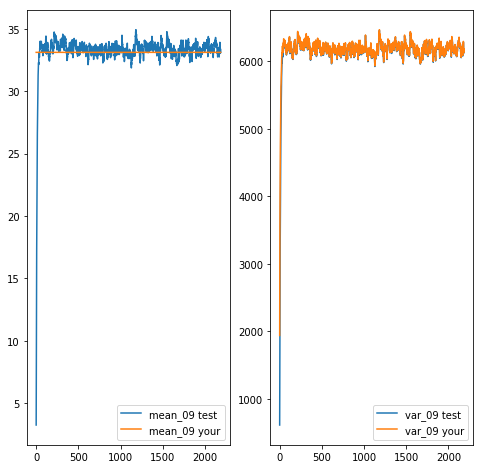

In [477]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


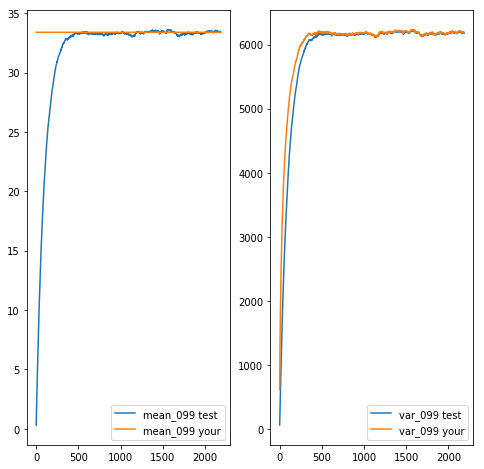

In [478]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


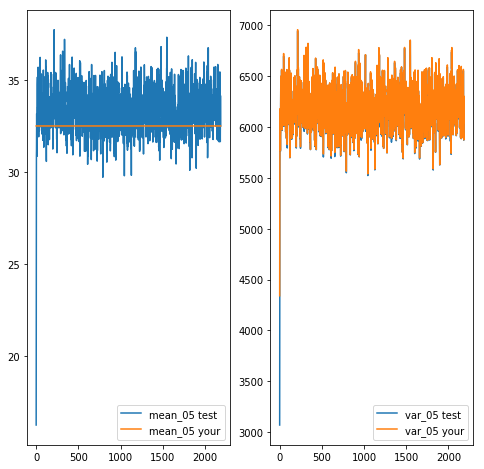

In [479]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [453]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
print (bn_09.runing_var)
print (bn_099.runing_var)
print (bn_05.runing_var)
#я хз правда как с этим справиться там значения почти не отличаются :(
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136 
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
tensor([6144.6626])
tensor([6189.5840])
tensor([6041.5933])


AssertionError: 

Посмотрим как повлияла батч нормализация на изображения

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


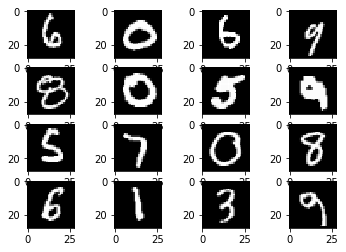

In [351]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тренировки
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    #assert (I == t_I).all(), "Что-то не так нормализованный тензор через running_mean и running_var не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [379]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут хранятся значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg.mul_(beta1)
                exp_avg.add_((1 - beta1) * grad)
                exp_avg_sq.mul_(beta2)
                exp_avg_sq.add_((1 - beta2) * grad**2)
                
                #step_size
                step_size = lr * (1 - beta2 ** state['step']) ** 2/(1 - beta1 ** state['step'])
                
                # обновляем веса в p.data,
                p.data.addcdiv_(-1 * step_size, exp_avg, (exp_avg_sq + eps) ** 0.5)
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [371]:
class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                
                m_t = -lr * grad
                
                if beta != 0:
                    state = self.state[p]
                    if len(state) == 0:                  
                        state['m_t'] = torch.zeros_like(p.data)

                    # тут можем достать сохраненные состояния
                    m_t = state['m_t']
                    m_t = beta*m_t - (1-beta)*grad
                
                # обновляем веса
                p.data.add_(lr*m_t)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [372]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [373]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [374]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [375]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [376]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.3570388782280572
Do epoch 1 with loss 0.11878024061411878
Do epoch 2 with loss 0.08756683673326371
Do epoch 3 with loss 0.07212657617872635
Do epoch 4 with loss 0.06278118097862534
Do epoch 5 with loss 0.05590972249495367
Do epoch 6 with loss 0.051304087141604525
Do epoch 7 with loss 0.04715392857135896
Do epoch 8 with loss 0.04400904192178283
Do epoch 9 with loss 0.04133675173504144
Do epoch 10 with loss 0.038932352140716185
Do epoch 11 with loss 0.03698776210954215
Do epoch 12 with loss 0.035278088627378856
Do epoch 13 with loss 0.033862969425439184
Do epoch 14 with loss 0.03219820364158231
Do epoch 15 with loss 0.030662409082279938
Do epoch 16 with loss 0.02969268577579608
Do epoch 17 with loss 0.028545265968771466
Do epoch 18 with loss 0.02793769771765507
Do epoch 19 with loss 0.026922673235677614


## SGD с моментом

In [377]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.34996288417270865
Do epoch 1 with loss 0.10030184137695829
Do epoch 2 with loss 0.07611982622339293
Do epoch 3 with loss 0.06383652211761824
Do epoch 4 with loss 0.05628212339661685
Do epoch 5 with loss 0.051061214977099464
Do epoch 6 with loss 0.04706269173717248
Do epoch 7 with loss 0.04337129009794742
Do epoch 8 with loss 0.04115530533377962
Do epoch 9 with loss 0.03833277650930372
Do epoch 10 with loss 0.03581515776106741
Do epoch 11 with loss 0.03448291968300455
Do epoch 12 with loss 0.03289903190359984
Do epoch 13 with loss 0.03131978031184829
Do epoch 14 with loss 0.02982817276814892
Do epoch 15 with loss 0.02865338839921005
Do epoch 16 with loss 0.027384338557215983
Do epoch 17 with loss 0.026533476371278925
Do epoch 18 with loss 0.025292024263370294
Do epoch 19 with loss 0.024405061060781615


## Adam

In [380]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.6298074696475328
Do epoch 1 with loss 0.06977635744199409
Do epoch 2 with loss 0.049098275982143266
Do epoch 3 with loss 0.041240144167546816
Do epoch 4 with loss 0.034662963840156574
Do epoch 5 with loss 0.03025922878523143
Do epoch 6 with loss 0.027320080076075604
Do epoch 7 with loss 0.025232004506895032
Do epoch 8 with loss 0.021872893597540594
Do epoch 9 with loss 0.02064541221869267
Do epoch 10 with loss 0.01884372596249749
Do epoch 11 with loss 0.016385310334234383
Do epoch 12 with loss 0.016400309981566195
Do epoch 13 with loss 0.0150668993532644
Do epoch 14 with loss 0.014482223745135256
Do epoch 15 with loss 0.012394601184328414
Do epoch 16 with loss 0.011876966935532635
Do epoch 17 with loss 0.011062233028538435
Do epoch 18 with loss 0.009651771630692817
Do epoch 19 with loss 0.009823030700247478


# Кривые обучения

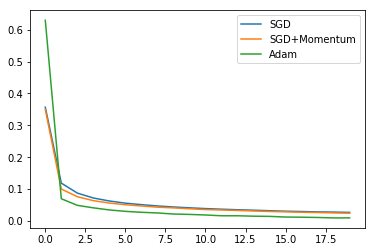

In [381]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO

## Лучший - ADAM